# Supplement B
# Drop Size Distribution retrieval


In the following, we introduce the use of the pyOptimalEstimation Python library using a radar-based drop-size distribution (DSD) retrieval as an example. 
\citep{williams_describing_2014} suggested to parameterize a DSD using a scaling parameter $N_w$ as well as the raindrop mass spectrum mean diameter $D_m$ and its standard deviation $\sigma_m$.
Assuming that the DSD follows a gamma distribution, $\sigma_m$ is related to the shape parameter $\mu$ with 
\begin{equation} 
    \mu = (D_m/\sigma)^2 -4
\end{equation}
and we reconstruct the original DSD $N(D)$ as a function of maximum dimension $D$ with
\begin{equation}
    N(D) = N_w \frac{6}{256} \frac{(4+\mu)^{\mu+4}}{\Gamma(\mu+4)} \Big(\frac{D}{D_m}\Big)^{\mu} \exp \Big[ -(4+\mu) \frac{D}{D_m}\Big]
\end{equation}
using the normalization approach by \citet{testud_concept_2001}.

\citet{williams_describing_2014} analyzed the correlations between $D_m$ and $\sigma_m$ in  detail and proposed to use a modified quantity $\sigma_m\!'$ defined with 
\begin{equation}
    \sigma_m\!' = \sigma_m D_m^{-1.36}
\end{equation}
in order to minimize the correlation to $D_m$. The three parameters required to estimate the DSD ($N_w$, $D_m$, and $\sigma_m$ or $\sigma_m\!'$) will form our state vector $\mathbf{x}$. 


A radar simulator will use $\mathbf{x}$ to estimate the measurement vector $\mathbf{y}$ consisting of the radar reflectivity factor ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$) with 
    \begin{equation}
    Z_e = 10 \times \log_{10} (10^{18} \times \sum_i N(D_i) \times \frac{\lambda^4}{|K_w|^2 \pi^5} \times \sigma(D_i) \times \Delta D ) 
    \end{equation}  
and
        \begin{equation}
V_d = \frac{\sum_i v(D_i) \times N(D_i) \times  \sigma(D_i) \times \Delta D}{\sum_i N(D_i) \times  \sigma(D_i) \times \Delta D}
    \end{equation}
where $i$ the index of the discrete DSD and $\sigma$ and $v$ are the functions to describe backscattering cross section and fall velocity, respectively. This means we have two measurements to derive three quantities of the state space, i.e. the problem is not unambiguous. 
In order to obtain the required prior data set, we use the Huntsville data set introduced in \citep{williams_describing_2014} which consists of 18969 individual DSD distributions obtained at Huntsville, AL from December 2009 to October 2011. For every DSD, \citet{williams_describing_2014} determined $N_w$, $D_m$, and $\sigma_m$ and we determine the a-priori assumption $\mathbf{x}_a$ and uncertainty ($\mathbb{S}_a$) form the mean and the covariance of the data set, respectively. 

This example has been developed using Python 3.6, Numpy 1.16.2, Matpolotlib 3.0.3, Scipy 1.2.1, Xarray 0.11.3, Pandas 0.24.1, Seaborn 0.9.0 and Uncertainties 3.0.3

All grey code blocks (cells) in this example can be modified for playing around. Each cell is executed with *shift+enter*. If you have never used Jupyter notebooks before, we recommend to check out the official tutorial: https://mybinder.org/v2/gh/ipython/ipython-in-depth/master?filepath=binder/Index.ipynb


# Installation 
In order to design a retrieval with pyOptimalEstimation, we need to install the library first with 
~~~~  
pip install pyOptimalEstimation
~~~~ 
for Python 2.7 or Python 3. This example uses Python 3.6. It requires the numpy, scipy, pandas and matplotlib libraries to be installed, this example makes use also of the xarray, seaborn, uncertainties, and xarray libraries. For development, we used Numpy 1.16.2, Matpolotlib 3.0.3, Scipy 1.2.1, Xarray 0.11.3, Pandas 0.24.1, Seaborn 0.9.0 and Uncertainties 3.0.3. 

The radar simulations are done with the Passive and Active Microwave radiative TRAnsfer model (PAMTRA) \citep{maahn_how_2015}. Here, we use version 2 that is in active development, so we install a specific version with:
~~~~ 
pip install git+git://github.com/maahn/pamtra2.git@461b711ae366b791665687de5dec37abd7ab78f5
~~~~ 



# Preparation

We start with loading the required libraries

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pn
import xarray as xr
import uncertainties.unumpy as unp
import seaborn as sns

import pamtra2

import pyOptimalEstimation as pyOE

%matplotlib inline
sns.set(style='ticks', palette='deep')
abc = 'abcdefghijklmopqrstuvwxyz'

We put some helper routines in a separate file which we load with 

In [2]:
import sys
sys.path.append('lib')
import supporting_routines
from importlib import reload
reload(supporting_routines)

<module 'supporting_routines' from 'lib/supporting_routines.py'>

## State vector


In order to load the required prior data set, we load the Huntsville data set of \citep{williams_describing_2014} from a netCDF file using xarray:

In [60]:
rainDat = xr.open_dataset('data/huntsville_parameters.nc')[['Dm','Nw','Smprime']]


and add logarithmic variables with

In [61]:
rainDat['Nw_log10'] = np.log10(rainDat['Nw'])
rainDat['Dm_log10'] = np.log10(rainDat['Dm'])
rainDat['Smprime_log10'] = np.log10(rainDat['Smprime'])

rainDat

<xarray.Dataset>
Dimensions:        (time: 18969)
Coordinates:
  * time           (time) datetime64[ns] 2009-12-13T04:24:00 ... 2011-04-04T21:51:00
Data variables:
    Dm             (time) float64 1.117 1.003 1.014 1.112 ... 1.377 1.475 1.476
    Nw             (time) float64 2.328e+03 4.55e+03 ... 3.125e+03 1.156e+03
    Smprime        (time) float64 0.3058 0.2524 0.2513 ... 0.3837 0.3386 0.3318
    Nw_log10       (time) float64 3.367 3.658 4.037 3.925 ... 3.581 3.495 3.063
    Dm_log10       (time) float64 0.04817 0.001143 0.00605 ... 0.1689 0.1692
    Smprime_log10  (time) float64 -0.5145 -0.598 -0.5999 ... -0.4703 -0.4791

We use 100 randomly chosen DSDs for the test data set and use the remaining DSDs for the training data set, i.e. to develop the retrieval.

In [62]:
nTest = 100

np.random.seed(10)
ii = np.arange(len(rainDat.time))
np.random.shuffle(ii)
testII, trainingII = ii[:nTest], ii[nTest:]

rainDat_test = rainDat.isel(time=testII)
rainDat_training = rainDat.isel(time=trainingII)

In order to asses the assumptions that the state variables follow a Gaussian distribution, we make QQ plots. Comparison of the first and second column reveals that a logarithmic state vector $\mathbf{x}$ is much closer to a Gaussian distribution than the linear version. Using a normalized  $\sigma_m\!'$ instead of $\sigma_m$ (third column) changes the the QQ plot only slightly. 

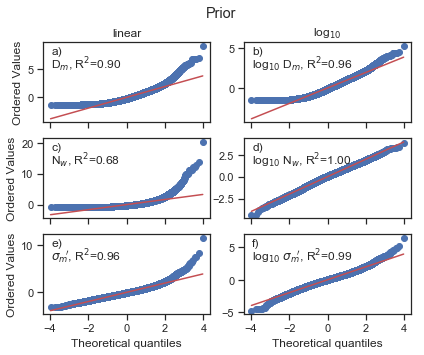

In [172]:
ncols = 2
fig, sps = plt.subplots(figsize=(6.6, 5), nrows=3, ncols=ncols, sharex=True)
fig.suptitle('Prior')
sps = sps.reshape((3, ncols))

jj = 0

for kk in range(3):
    for ii, (x_name, x_vars) in enumerate([
        ('linear', ['Dm', 'Nw', 'Smprime']),
        ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
    ]):

        x_var = x_vars[kk]
        data = (rainDat_training[x_var] - np.mean(rainDat_training[x_var])) / np.std(rainDat_training[x_var] )
        (osm, osr), (slope, intercept, r) = stats.probplot(
            data,
            dist="norm",
            plot=sps[kk, ii],
            fit=True,
            rvalue=False)

        if kk > 0:
            sps[kk, ii].set_title('')
        else:
            sps[kk, ii].set_title(x_name)

        sps[kk, ii].text(
            0.05,
            0.95,
            '%s)' % (abc[jj]),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[kk, ii].transAxes)
        sps[kk, ii].text(
            0.05,
            0.85,
            '%s, R$^2$=%.2f' % (
                supporting_routines.niceKeys[x_var], r**2
                #, x_mean, x_std
            ),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[kk, ii].transAxes)

        if kk < 2:
            sps[kk, ii].set_xlabel("")
        if ii > 0:
            sps[kk, ii].set_ylabel("")
        jj += 1

# fig.tight_layout(pad=0.1, h_pad=0, w_pad=0.)
fig.savefig('qq_x_lin_log.png')

The prior $\mathbf{x}_{a}$ and covariance $\mathbb{S}_a$ of the state vector are estimated from the training data set. For convenience, we estimate it for the linear and logarithmic variables together and select the required quantities later. 

In [68]:
S_a = rainDat_training.to_dataframe().cov()
x_ap = rainDat_training.to_dataframe().mean()
print(x_ap)
print(S_a)

Dm                  1.461640
Nw               4054.575495
Smprime             0.299574
Nw_log10            3.436274
Dm_log10            0.153298
Smprime_log10      -0.530466
dtype: float64
                       Dm            Nw    Smprime     Nw_log10    Dm_log10  \
Dm               0.128514 -4.313570e+02  -0.000075    -0.055004    0.034559   
Nw            -431.356978  1.825811e+07 -32.369253  1364.035418 -124.718395   
Smprime         -0.000075 -3.236925e+01   0.002993    -0.002567    0.000055   
Nw_log10        -0.055004  1.364035e+03  -0.002567     0.157103   -0.015119   
Dm_log10         0.034559 -1.247184e+02   0.000055    -0.015119    0.009550   
Smprime_log10    0.000101 -4.948687e+01   0.004192    -0.003630    0.000150   

               Smprime_log10  
Dm                  0.000101  
Nw                -49.486873  
Smprime             0.004192  
Nw_log10           -0.003630  
Dm_log10            0.000150  
Smprime_log10       0.006027  


When estimating the prior, the use of SI units is not always recommended: Combining small and large quantities with different units (e.g. temperature in K and specific humidity in kg/kg), the prior can be singular prohibiting an efficient use. $\mathbb{S}_a$ is visualized

In [69]:
# fig, [sp1, sp2, sp3] = plt.subplots(ncols=3)
# supporting_routines.plotCorrelation(
#     S_a[['Dm', 'Nw', 'Sm']].loc[['Dm', 'Nw', 'Sm']],
#     fig,
#     sp1,
#     tickLabels=supporting_routines.niceKeys)
# supporting_routines.plotCorrelation(
#     S_a[['Dm_log10', 'Nw_log10',
#          'Sm_log10']].loc[['Dm_log10', 'Nw_log10', 'Sm_log10']],
#     fig,
#     sp2,
#     tickLabels=supporting_routines.niceKeys)

# supporting_routines.plotCorrelation(
#     S_a[['Dm_log10', 'Nw_log10',
#          'Smprime_log10']].loc[['Dm_log10', 'Nw_log10', 'Smprime_log10']],
#     fig,
#     sp3,
#     tickLabels=supporting_routines.niceKeys)

# #
# fig.tight_layout(pad=0.1, h_pad=0, w_pad=0.2)
# fig.savefig('x_corr.pdf')

## Measurement space
The measurement vector $\mathbf{y}$ consists of the radar reflectivity factor ($Z$) and the mean Doppler velocity ($V_d$) at 13.6 GHz and 35.5 GHz. Even though we use only 35.5 GHz in the following, we encourage the reader to experiment with different $\mathbf{y}$ combinations. For  $\mathbb{S}_y$, we assume that the uncertainties of  $Z$ and $V_d$ are 1 dB and 0.3 m s$^{-1}$, respectively, and that the errors are not correlated. Even though these error estimates are generally realistic, the values should be carefully evaluated for a real world application.

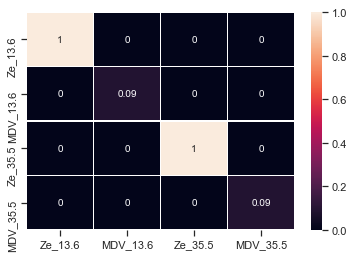

In [70]:
y_vars = ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]
y_noise = np.array([1, .3, 1, .3])
S_y = pn.DataFrame(
    np.diag(y_noise**2),
    index=y_vars,
    columns=y_vars,
)
sns.heatmap(S_y, annot=True, fmt='g', linewidths=.05)

## Retrieval
To prepare the retrieval, we set up PAMTRA2 properly and create dictionaries to store the results.

In [71]:
pam2Prepared = supporting_routines.preparePamtra(frequencies=[13.6e9, 35.5e9])
resultsOE = {}
failed = {}

Did not find information about relativePermittivityIce. This might cause trouble later.


/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:170: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos((cos_sca-cos_th*cos_inc)/(sin_th*sin_inc))
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:171: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.arccos((cos_inc-cos_th*cos_sca)/(sin_th*sin_sca))


We run the retrieval for three configurations:

1. linear state variables
2. logarithmic state variables
3. logarithmic state variables with enhanced noise

In [72]:
x_names = dict([
    ('Linear', ['Dm', 'Nw', 'Smprime']),
    ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
])

In this study, we use only a measurement configuration consisting of a radar reflectivity ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$). But the example is designed to work also with dual-frequency set ups and we encourage the reader to play around with these. 

The number in the last column is for a factor which is applied to the estimated measurement noise that allows to study the impact of measurement uncertainty on retrieval performance.

In [73]:
y_names = dict([
    #     name, [Y_variables],
    #     ('Z', ["Ze_13.6"]),
    ('ZW', ["Ze_13.6", "MDV_13.6"]),
    #     ('Zdual', ["Ze_13.6", "Ze_35.5"]),
    #     ('ZWdual', ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]),
])


# Example retrieval

to do: go step by step through retrieval design

In [74]:
tt = np.argmin(np.abs(rainDat_test['Dm'] - 1.202))
rainDat_test.isel(time=tt), tt

(<xarray.Dataset>
 Dimensions:        ()
 Coordinates:
     time           datetime64[ns] 2010-01-17T08:15:00
 Data variables:
     Dm             float64 1.202
     Nw             float64 5.823e+03
     Smprime        float64 0.4368
     Nw_log10       float64 3.765
     Dm_log10       float64 0.07995
     Smprime_log10  float64 -0.3597, <xarray.DataArray 'Dm' ()>
 array(51))

In [76]:
for x_name, y_name, y_uncertainty_factor in (
    ('Linear', 'ZW', 1),
    ('log$_{10}$', 'ZW', 1),
    ('log$_{10}$', 'ZW', 2),
):
    for tt in [51]:
        x_vars = x_names[x_name]
        y_vars = y_names[y_name]

        #Additional required variables for the forward operator
        forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

        print('#' * 80)
        print(x_name, y_name, y_uncertainty_factor)
        print('#' * 80)



        x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]

        # simulate observation based on true state x_truth
        y_obs = supporting_routines.forwardPamtra(
            x_truth,
            pam2=pam2Prepared,
            y_vars=y_vars,
        )

        # create optimal estimation object
        oe = pyOE.optimalEstimation(
            x_vars,  # state variable names
            x_ap[x_vars],  # a priori
            S_a[x_vars].loc[x_vars],  # a priori uncertainty
            y_vars,  # measurement variable names
            y_obs,  # observations
            S_y[y_vars].loc[y_vars] * y_uncertainty_factor**
            2,  # observation uncertainty
            supporting_routines.forwardPamtra,  # forward Operator
            forwardKwArgs=forwardKwArgs,  # additonal function arguments
        )

        # Store true profile in `oe` object. This is just for simplicity, it is not
        # used by the retrieval.
        oe.x_truth = x_truth

        # Do the retrieval with max. 10 iterations.
        converged = oe.doRetrieval(maxIter=10)

        if converged:

            # Test whethe rthe retrieval is moderately lienar around x_truth
            oe.linearityTest()

            # Show hdegrees of freedom per variable
            print(oe.dgf_x)

            # Show RMS normalized with prior
            print('RMS', np.sqrt(
                np.mean(((oe.x_truth - oe.x_op) / oe.x_a)**2)))

            # Apply chi2 tests for retrieval quality
            print(oe.chiSquareTest())

            oe.summarize(returnXarray=True)

################################################################################
Linear ZW 1
################################################################################
0.29 s, iteration 1, degrees of freedom: 1.92 of 3. convergence criteria NOT fullfilled  1.375
0.40 s, iteration 2, degrees of freedom: 1.91 of 3. convergence criteria fullfilled  0.001
0.51 s, iteration 3, degrees of freedom: 1.91 of 3.  Done.  0.000
Dm         0.904881
Nw         0.881159
Smprime    0.123292
dtype: float64
RMS 0.5938271695438153
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.274115
Y_Observation_vs_Prior      0.165154
Y_Optimal_vs_Prior          0.161365
X_Optimal_vs_Prior          0.257174
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5

# Run retrieval
The retrieval is run for all test profiles and all sets of state and measurement variables. 


For simplicity, we use a synthetic observations, i.e. we use PAMTRA2 to simulate an observation based on a known atmospheric state $\mathbf{x}_{truth}$. Even though $\mathbf{x}_{truth}$ is typically unknown in a real-world example, the use of synthetic observations is extremely helpful for assessing retrieval performance. 

The forward operator `forwardPamtra` is simply a Python function accepting $\mathbf{x}$ as an input. Additionally required function arguments are provided through the `forwardKwArgs` dictionary.

The `pyOptimalEstimation` library is object oriented, i.e., we need to create the `oe` object first before running the retrieval with `oe.doRetrieval`. 

If the retrieval converged, we use different measures to evaluate the retrieval quality:
1. Linearity test tests whether the problem is moderately linear following chapter 5.1 of Rodgers (2000). Values lower than 1 indicate that the effect of linearization is smaller than the measurement error and problem is nearly linear. In case $\mathbf{x}_{truth}$  is not available, error patterns of $\mathbb{S}$ can be used instead. 
2. The degrees of freedom for signal (dgf) for each individual variable. 
3. RMS: The root mean square error between the true profile $\mathbf{x}_{truth}$ and the retrieval result $\mathbf{x}_{optimal}$. We normalize with $\mathbf{x}_{a}$ to account for the different units. 
4. $\chi^2$ tests: We use four $\chi^2$ tests as described in chapter 12 of Rodgers (2000). We test whether
    1. the retrieved state $\mathbf{x}_{op}$ agrees with the prior $\mathbb{S}_a$
    2. the observation $\mathbf{y}_{truth}$ corresponding to $\mathbf{x}_{truth}$ agrees with the prior $\mathbb{S}_a$
    3. $\mathbf{y}_{truth}$  agrees with the measurement $\mathbf{y}_{obs}$ given the uncertainties $\mathbb{S}_y$ 
    4. the measurement $\mathbf{y}_{obs}$ agrees with the prior $\mathbb{S}_a$

In [77]:
for x_name, y_name, y_uncertainty_factor in (
    ('Linear', 'ZW', 1),
    ('log$_{10}$', 'ZW', 1),
#     ('log$_{10}$', 'ZW', 2),
):

    x_vars = x_names[x_name]
    y_vars = y_names[y_name]

    resultsOE['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)] = []
    failed['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)] = []

    #Additional required variables for the forward operator
    forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

    print('#' * 80)
    print(x_name, y_name, y_uncertainty_factor)
    print('#' * 80)

#     for tt in [15, 20, 51]:
    for tt in range(rainDat_test[x_vars].time.shape[0]):

        x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]
        # simulate observation based on true state x_truth
        y_obs = supporting_routines.forwardPamtra(
            x_truth,
            pam2=pam2Prepared,
            y_vars=y_vars,
        )

        # create optimal estimation object
        oe = pyOE.optimalEstimation(
            x_vars,  # state variable names
            x_ap[x_vars],  # a priori
            S_a[x_vars].loc[x_vars],  # a priori uncertainty
            y_vars,  # measurement variable names
            y_obs,  # observations
            S_y[y_vars].loc[y_vars] * y_uncertainty_factor**
            2,  # observation uncertainty
            supporting_routines.forwardPamtra,  # forward Operator
            forwardKwArgs=forwardKwArgs,  # additonal function arguments
        )

        # Store true profile in `oe` object. This is just for convenience, it is not
        # used by the retrieval.
        oe.x_truth = x_truth

        # Do the retrieval with max. 10 iterations.
        converged = oe.doRetrieval(maxIter=10)

        if converged:

            # Test whethe rthe retrieval is moderately lienar around x_truth
            print(oe.linearityTest())

            # Show hdegrees of freedom per variable
            print(oe.dgf_x)

            # Apply chi2 tests for retrieval quality
            print(oe.chiSquareTest())

            if x_name.startswith('log'):
                # Show RMS normalized with prior
                print('RMS log', np.sqrt(
                    np.mean(((10**oe.x_truth - 10**oe.x_op) / 10**oe.x_a)**2)))
                print('truth', 10**oe.x_truth)
                print('op', 10**unp.uarray(oe.x_op.values,
                                         oe.x_op_err.values))
            else:
                # Show RMS normalized with prior
                print('RMS', np.sqrt(
                    np.mean(((oe.x_truth - oe.x_op) / oe.x_a)**2)))
                print('truth', oe.x_truth)
                print('op', unp.uarray(oe.x_op.values,
                                         oe.x_op_err.values))
                
            #Store results in xarray DataArray
            summary = oe.summarize(returnXarray=True)
            resultsOE['%s_%s_%i' % (x_name, y_name,
                                    y_uncertainty_factor)].append(summary)
        else:
            failed['%s_%s_%i' % (x_name, y_name,
                                 y_uncertainty_factor)].append(tt)
    #Store results in xarray Dataset structure for later analysis.
    resultsOE['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)] = xr.concat(
        resultsOE['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)],
        dim='time')
    
# resultsOEs = xr.concat(resultsOE.values(), dim='configuration')
# resultsOEs['configuration'] = list(resultsOE.keys())
# resultsOEs[].to_dataframe().reset_index()

################################################################################
Linear ZW 1
################################################################################
0.24 s, iteration 1, degrees of freedom: 1.77 of 3. convergence criteria fullfilled  0.017
0.35 s, iteration 2, degrees of freedom: 1.77 of 3.  Done.  0.000
([1.31664499661615, 0.00067507598515647, 0.0005244346764850746], array(0.06722079), 5.991464547107983)
Dm         0.967234
Nw         0.610596
Smprime    0.196107
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.170134
Y_Observation_vs_Prior      0.163760
Y_Optimal_vs_Prior          0.166656
X_Optimal_vs_Prior          0.161910
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Obser

0.25 s, iteration 1, degrees of freedom: 1.94 of 3. convergence criteria NOT fullfilled  3.753
0.35 s, iteration 2, degrees of freedom: 1.92 of 3. convergence criteria fullfilled  0.001
0.49 s, iteration 3, degrees of freedom: 1.92 of 3.  Done.  0.000
([6.796875046063077, 0.0013430031961420253, 0.0001778116391400857], array(0.04821977), 5.991464547107983)
Dm         0.902085
Nw         0.908848
Smprime    0.111050
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.439910
Y_Observation_vs_Prior      0.208485
Y_Optimal_vs_Prior          0.204488
X_Optimal_vs_Prior          0.364131
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal

/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.24 s, iteration 1, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfilled  15.879
0.35 s, iteration 2, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  193.929
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 3
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 3
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 3
0.49 s, iteration 3, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfi

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 3
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 3
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 3
0.54 s, iteration 3, degrees of freedom: 0.88 of 3. convergence criteria NOT fullfilled  14.529
0.68 s, iteration 4, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  61.876
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 5
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 5
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 5
0.86 s, iteration 5, degrees of freedom: 0.88 of 3. convergence criteria NOT fullfil

0.54 s, iteration 1, degrees of freedom: 1.69 of 3. convergence criteria NOT fullfilled  21.275
1.13 s, iteration 2, degrees of freedom: 1.55 of 3. convergence criteria NOT fullfilled  0.403
1.65 s, iteration 3, degrees of freedom: 1.54 of 3. convergence criteria fullfilled  0.137
2.40 s, iteration 4, degrees of freedom: 1.55 of 3.  Done.  0.076
([4.465147361366826, 0.0026575111496453946, 0.0007264134977964424], array(164.90708527), 5.991464547107983)
Dm         0.628634
Nw         0.753585
Smprime    0.166226
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool, chi2test
Y_Optimal_vs_Observation    17.500753
Y_Observation_vs_Prior      43.089511
Y_Optimal_vs_Prior          66.708841
X_Optimal_vs_Prior          16.938746
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_O

0.46 s, iteration 3, degrees of freedom: 1.91 of 3.  Done.  0.000
([5.776111889582011, 0.0010488243812035438, 0.0006057006920062899], array(0.24441801), 5.991464547107983)
Dm         0.940750
Nw         0.893072
Smprime    0.079610
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.283374
Y_Observation_vs_Prior      0.936047
Y_Optimal_vs_Prior          0.935063
X_Optimal_vs_Prior          1.189404
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.21741959955239828
truth Dm            1.079676
Nw         3174.033095
Smprime       0.366346
Name: 2010-10-21 02:50:

1.31 s, iteration 8, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  34.458
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 9
1.43 s, iteration 9, degrees of freedom: 0.95 of 3. convergence criteria NOT fullfilled  1.963
0.47 s, iteration 1, degrees of freedom: 1.59 of 3. convergence criteria NOT fullfilled  1.285
0.60 s, iteration 2, degrees of freedom: 1.59 of 3. convergence criteria fullfilled  0.001
0.93 s, iteration 3, degrees of freedom: 1.59 of 3.  Done.  0.000
([0.10326384960033312, 0.001976655417084655, 0.0006508268233795794], array(0.10490149), 5.991464547107983)
Dm         0.997677
Nw         0.379306
Smprime    0.211146
dtype: float64
Warning. Sing

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.24 s, iteration 1, degrees of freedom: 0.95 of 3. convergence criteria NOT fullfilled  4.006
0.50 s, iteration 2, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  53.591
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 3
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 3
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 3
0.65 s, iteration 3, degrees of freedom: 0.95 of 3. convergence criteria NOT fullfill

0.32 s, iteration 1, degrees of freedom: 1.71 of 3. convergence criteria fullfilled  0.139
0.46 s, iteration 2, degrees of freedom: 1.71 of 3.  Done.  0.000
([0.7845655632671938, 0.0007311549017471492, 0.00042775105539265106], array(0.00049912), 5.991464547107983)
Dm         0.982098
Nw         0.510025
Smprime    0.215189
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.524117
Y_Observation_vs_Prior      0.600364
Y_Optimal_vs_Prior          0.658275
X_Optimal_vs_Prior          0.504513
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.06306534661504129
truth

0.32 s, iteration 1, degrees of freedom: 1.92 of 3. convergence criteria NOT fullfilled  1.375
0.44 s, iteration 2, degrees of freedom: 1.91 of 3. convergence criteria fullfilled  0.001
0.61 s, iteration 3, degrees of freedom: 1.91 of 3.  Done.  0.000
([5.666036087335593, 0.001473405253310826, 0.00013354542546119814], array(10.52868809), 5.991464547107983)
Dm         0.904881
Nw         0.881159
Smprime    0.123292
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.274115
Y_Observation_vs_Prior      0.165154
Y_Optimal_vs_Prior          0.161365
X_Optimal_vs_Prior          0.257174
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optima

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 7
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 7
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 7
1.01 s, iteration 7, degrees of freedom: 0.91 of 3. convergence criteria NOT fullfilled  9.952
1.16 s, iteration 8, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  20.416
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 9
1.29 s, iteration 9, degrees of freedom: 0.91 of 3. convergence criteria NOT fullfill

0.24 s, iteration 1, degrees of freedom: 1.68 of 3. convergence criteria NOT fullfilled  0.433
0.35 s, iteration 2, degrees of freedom: 1.69 of 3. convergence criteria fullfilled  0.001
0.46 s, iteration 3, degrees of freedom: 1.68 of 3.  Done.  0.000
([0.767337194190131, 0.0017933320323577735, 2.5244153769885907e-05], array(0.00585909), 5.991464547107983)
Dm         0.953453
Nw         0.450274
Smprime    0.280160
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.141261
Y_Observation_vs_Prior      1.409772
Y_Optimal_vs_Prior          1.455238
X_Optimal_vs_Prior          1.178347
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optima

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 3
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 3
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 3
0.55 s, iteration 3, degrees of freedom: 0.89 of 3. convergence criteria NOT fullfilled  17.940
0.69 s, iteration 4, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  32.750
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 5
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 5
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 5
0.84 s, iteration 5, degrees of freedom: 0.89 of 3. convergence criteria NOT fullfil

0.24 s, iteration 1, degrees of freedom: 1.64 of 3. convergence criteria NOT fullfilled  0.579
0.36 s, iteration 2, degrees of freedom: 1.64 of 3. convergence criteria fullfilled  0.000
0.51 s, iteration 3, degrees of freedom: 1.64 of 3.  Done.  0.000
([0.46736864903412595, 0.0008628125648783515, 0.000353769138700646], array(0.01264103), 5.991464547107983)
Dm         0.990767
Nw         0.418213
Smprime    0.232109
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.218548
Y_Observation_vs_Prior      1.692797
Y_Optimal_vs_Prior          2.009413
X_Optimal_vs_Prior          1.214828
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optima

0.26 s, iteration 1, degrees of freedom: 1.95 of 3. convergence criteria NOT fullfilled  45.336
0.37 s, iteration 2, degrees of freedom: 1.94 of 3. convergence criteria NOT fullfilled  0.305
0.50 s, iteration 3, degrees of freedom: 1.93 of 3. convergence criteria fullfilled  0.002
0.65 s, iteration 4, degrees of freedom: 1.93 of 3.  Done.  0.000
([9.565389590907811, 0.0016463238480514363, 0.0002795382643544726], array(0.18924361), 5.991464547107983)
Dm         0.946823
Nw         0.929625
Smprime    0.050602
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.579397
Y_Observation_vs_Prior      1.747457
Y_Optimal_vs_Prior          1.753508
X_Optimal_vs_Prior          2.341555
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation

0.33 s, iteration 1, degrees of freedom: 1.91 of 3. convergence criteria NOT fullfilled  0.602
0.50 s, iteration 2, degrees of freedom: 1.90 of 3. convergence criteria fullfilled  0.000
0.79 s, iteration 3, degrees of freedom: 1.89 of 3.  Done.  0.000
([5.09394249137846, 0.0017399924722143838, 6.437786465811535e-05], array(1.32517292), 5.991464547107983)
Dm         0.901512
Nw         0.854829
Smprime    0.138490
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.186271
Y_Observation_vs_Prior      0.134340
Y_Optimal_vs_Prior          0.130832
X_Optimal_vs_Prior          0.182482
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 7
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 7
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 7
1.02 s, iteration 7, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfilled  25.315
1.16 s, iteration 8, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  268.041
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 9
1.30 s, iteration 9, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfi

0.46 s, iteration 1, degrees of freedom: 1.82 of 3. convergence criteria fullfilled  0.003
0.73 s, iteration 2, degrees of freedom: 1.82 of 3.  Done.  0.000
([1.9848280577538169, 0.0010109095175106207, 0.0003192752786278283], array(0.03702267), 5.991464547107983)
Dm         0.950648
Nw         0.690578
Smprime    0.178647
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.055638
Y_Observation_vs_Prior      0.053258
Y_Optimal_vs_Prior          0.053227
X_Optimal_vs_Prior          0.053968
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.20300605692078597
truth 

0.30 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.007
0.41 s, iteration 2, degrees of freedom: 1.77 of 3.  Done.  0.000
([0.010245929625697519, 0.00042280090111840773, 0.00017657269207544234], array(0.00199259), 5.991464547107983)
Dm_log10         0.952250
Nw_log10         0.656234
Smprime_log10    0.166329
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.169331
Y_Observation_vs_Prior      0.176418
Y_Optimal_vs_Prior          0.177609
X_Optimal_vs_Prior          0.167549
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 

0.49 s, iteration 1, degrees of freedom: 1.72 of 3. convergence criteria NOT fullfilled  0.630
0.65 s, iteration 2, degrees of freedom: 1.71 of 3. convergence criteria fullfilled  0.000
0.80 s, iteration 3, degrees of freedom: 1.71 of 3.  Done.  0.000
([0.009531984358981373, 0.000136029902042968, 6.648974329959327e-05], array(0.08325564), 5.991464547107983)
Dm_log10         0.948767
Nw_log10         0.641796
Smprime_log10    0.123012
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    3.970047
Y_Observation_vs_Prior      4.242244
Y_Optimal_vs_Prior          4.243530
X_Optimal_vs_Prior          3.969280
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior        

0.50 s, iteration 1, degrees of freedom: 1.76 of 3. convergence criteria fullfilled  0.047
0.63 s, iteration 2, degrees of freedom: 1.76 of 3.  Done.  0.000
([0.011578622544570883, 0.0002559226375298337, 0.00017910644272481346], array(0.00697838), 5.991464547107983)
Dm_log10         0.953780
Nw_log10         0.661391
Smprime_log10    0.145042
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.744942
Y_Observation_vs_Prior      0.817763
Y_Optimal_vs_Prior          0.836246
X_Optimal_vs_Prior          0.742361
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.25 s, iteration 1, degrees of freedom: 1.73 of 3. convergence criteria NOT fullfilled  0.349
0.37 s, iteration 2, degrees of freedom: 1.73 of 3. convergence criteria fullfilled  0.000
0.58 s, iteration 3, degrees of freedom: 1.73 of 3.  Done.  0.000
([0.010771932552596624, 0.00014170301828832278, 9.875261461971162e-05], array(0.00413312), 5.991464547107983)
Dm_log10         0.951991
Nw_log10         0.654708
Smprime_log10    0.120321
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.477639
Y_Observation_vs_Prior      1.893620
Y_Optimal_vs_Prior          1.999268
X_Optimal_vs_Prior          1.477296
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior      

0.25 s, iteration 1, degrees of freedom: 1.79 of 3. convergence criteria fullfilled  0.000
0.37 s, iteration 2, degrees of freedom: 1.79 of 3.  Done.  0.000
([0.007156424065525649, 0.0008544796330691788, 0.00010269289262835075], array(0.00246449), 5.991464547107983)
Dm_log10         0.948266
Nw_log10         0.641509
Smprime_log10    0.199394
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.358087
Y_Observation_vs_Prior      0.356185
Y_Optimal_vs_Prior          0.355603
X_Optimal_vs_Prior          0.358142
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.27 s, iteration 1, degrees of freedom: 1.77 of 3. convergence criteria fullfilled  0.006
0.40 s, iteration 2, degrees of freedom: 1.77 of 3.  Done.  0.000
([0.0050278875394599454, 0.0007404606073968018, 4.0561537764724956e-05], array(0.00073908), 5.991464547107983)
Dm_log10         0.954060
Nw_log10         0.633651
Smprime_log10    0.177464
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    3.585795
Y_Observation_vs_Prior      3.453021
Y_Optimal_vs_Prior          3.423242
X_Optimal_vs_Prior          3.579144
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 

0.27 s, iteration 1, degrees of freedom: 1.77 of 3. convergence criteria fullfilled  0.025
0.46 s, iteration 2, degrees of freedom: 1.77 of 3.  Done.  0.000
([0.011132631096051414, 0.00030109951186423534, 0.0001815443406781971], array(0.00219652), 5.991464547107983)
Dm_log10         0.954081
Nw_log10         0.661554
Smprime_log10    0.150048
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.791803
Y_Observation_vs_Prior      0.836369
Y_Optimal_vs_Prior          0.848232
X_Optimal_vs_Prior          0.791122
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.27 s, iteration 1, degrees of freedom: 1.79 of 3. convergence criteria fullfilled  0.000
0.38 s, iteration 2, degrees of freedom: 1.79 of 3.  Done.  0.000
([0.006117283426276139, 0.0009672238104204932, 6.675291705639815e-05], array(0.30744798), 5.991464547107983)
Dm_log10         0.948290
Nw_log10         0.636926
Smprime_log10    0.202494
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.125084
Y_Observation_vs_Prior      0.124129
Y_Optimal_vs_Prior          0.123875
X_Optimal_vs_Prior          0.124958
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.

0.32 s, iteration 1, degrees of freedom: 1.79 of 3. convergence criteria fullfilled  0.000
0.45 s, iteration 2, degrees of freedom: 1.79 of 3.  Done.  0.000
([0.006637230128801533, 0.000978597493690235, 9.482613142833369e-05], array(0.54100336), 5.991464547107983)
Dm_log10         0.946153
Nw_log10         0.636441
Smprime_log10    0.210515
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.214520
Y_Observation_vs_Prior      1.202212
Y_Optimal_vs_Prior          1.198510
X_Optimal_vs_Prior          1.214143
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.3

0.24 s, iteration 1, degrees of freedom: 1.74 of 3. convergence criteria fullfilled  0.061
0.38 s, iteration 2, degrees of freedom: 1.74 of 3.  Done.  0.000
([0.0022864705519447226, 0.0007080295138769989, 0.0001131594698688141], array(0.10086126), 5.991464547107983)
Dm_log10         0.945320
Nw_log10         0.587572
Smprime_log10    0.210922
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.534563
Y_Observation_vs_Prior      1.587062
Y_Optimal_vs_Prior          1.607758
X_Optimal_vs_Prior          1.539006
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.26 s, iteration 1, degrees of freedom: 1.68 of 3. convergence criteria NOT fullfilled  0.575
0.39 s, iteration 2, degrees of freedom: 1.67 of 3. convergence criteria fullfilled  0.001
0.53 s, iteration 3, degrees of freedom: 1.67 of 3.  Done.  0.000
([0.0002858979790168937, 0.0002642347318241621, 2.5536823398975017e-05], array(0.00025812), 5.991464547107983)
Dm_log10         0.930299
Nw_log10         0.534587
Smprime_log10    0.204023
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation     True
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior           True
dtype: bool, chi2test
Y_Optimal_vs_Observation    5.553849
Y_Observation_vs_Prior      8.091558
Y_Optimal_vs_Prior          9.133353
X_Optimal_vs_Prior          5.525025
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior 

0.25 s, iteration 1, degrees of freedom: 1.76 of 3. convergence criteria fullfilled  0.032
0.38 s, iteration 2, degrees of freedom: 1.76 of 3.  Done.  0.000
([0.0027944251722434406, 0.000879788119640204, 8.332665870620321e-05], array(4.83454563e-06), 5.991464547107983)
Dm_log10         0.946287
Nw_log10         0.598972
Smprime_log10    0.211102
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.995314
Y_Observation_vs_Prior      1.007494
Y_Optimal_vs_Prior          1.016675
X_Optimal_vs_Prior          0.993302
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS lo

0.24 s, iteration 1, degrees of freedom: 1.76 of 3. convergence criteria fullfilled  0.049
0.38 s, iteration 2, degrees of freedom: 1.76 of 3.  Done.  0.000
([0.011623871065511087, 0.00026732075325365594, 0.00017904993830225688], array(1.03547611e-05), 5.991464547107983)
Dm_log10         0.952532
Nw_log10         0.658323
Smprime_log10    0.149827
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.479956
Y_Observation_vs_Prior      0.531387
Y_Optimal_vs_Prior          0.540734
X_Optimal_vs_Prior          0.470695
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 

0.29 s, iteration 1, degrees of freedom: 1.76 of 3. convergence criteria fullfilled  0.079
0.43 s, iteration 2, degrees of freedom: 1.75 of 3.  Done.  0.000
([0.011798317776780061, 0.00022398679218214653, 0.0001682807140364314], array(0.00899288), 5.991464547107983)
Dm_log10         0.953177
Nw_log10         0.659974
Smprime_log10    0.141148
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.702690
Y_Observation_vs_Prior      0.806487
Y_Optimal_vs_Prior          0.830838
X_Optimal_vs_Prior          0.695356
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

################################################################################
log$_{10}$ ZW 2
################################################################################
0.29 s, iteration 1, degrees of freedom: 1.43 of 3. convergence criteria fullfilled  0.000
0.42 s, iteration 2, degrees of freedom: 1.43 of 3.  Done.  0.000
([0.0048729215779028615, 0.00033160801095427514, 8.735777956937357e-05], array(0.00548582), 5.991464547107983)
Dm_log10         0.911153
Nw_log10         0.407742
Smprime_log10    0.114174
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.184058
Y_Observation_vs_Prior      0.185114
Y_Optimal_vs_Prior          0.186095
X_Optimal_vs_Prior          0.184023
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_O

0.27 s, iteration 1, degrees of freedom: 1.45 of 3. convergence criteria fullfilled  0.000
0.41 s, iteration 2, degrees of freedom: 1.45 of 3.  Done.  0.000
([0.004369157190568068, 0.0002446560455242355, 5.7570727459535596e-05], array(0.00333039), 5.991464547107983)
Dm_log10         0.911318
Nw_log10         0.404848
Smprime_log10    0.129314
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.177149
Y_Observation_vs_Prior      0.176615
Y_Optimal_vs_Prior          0.176017
X_Optimal_vs_Prior          0.177156
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.26 s, iteration 1, degrees of freedom: 1.36 of 3. convergence criteria fullfilled  0.026
0.39 s, iteration 2, degrees of freedom: 1.37 of 3.  Done.  0.000
([0.000895180265292611, 0.00035850895816998856, 0.0002701341255331371], array(0.00143492), 5.991464547107983)
Dm_log10         0.899791
Nw_log10         0.328911
Smprime_log10    0.136848
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.288692
Y_Observation_vs_Prior      2.830056
Y_Optimal_vs_Prior          3.605683
X_Optimal_vs_Prior          2.260484
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.35 s, iteration 1, degrees of freedom: 1.38 of 3. convergence criteria fullfilled  0.014
0.50 s, iteration 2, degrees of freedom: 1.38 of 3.  Done.  0.000
([0.0013038182306488242, 0.0002555783527575224, 0.00018837996025993076], array(1.04296704e-05), 5.991464547107983)
Dm_log10         0.907067
Nw_log10         0.342407
Smprime_log10    0.129812
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.687326
Y_Observation_vs_Prior      1.733551
Y_Optimal_vs_Prior          1.809739
X_Optimal_vs_Prior          1.690657
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 

0.38 s, iteration 1, degrees of freedom: 1.40 of 3. convergence criteria fullfilled  0.013
0.50 s, iteration 2, degrees of freedom: 1.40 of 3.  Done.  0.000
([0.0014909391159455645, 0.00021119792411736736, 0.00013080517393948036], array(0.0028422), 5.991464547107983)
Dm_log10         0.907244
Nw_log10         0.352012
Smprime_log10    0.140728
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.173081
Y_Observation_vs_Prior      1.321321
Y_Optimal_vs_Prior          1.527241
X_Optimal_vs_Prior          1.159664
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 

0.38 s, iteration 1, degrees of freedom: 1.36 of 3. convergence criteria fullfilled  0.068
0.54 s, iteration 2, degrees of freedom: 1.35 of 3.  Done.  0.000
([0.004519309062070855, 0.00022470761443372, 0.0002108913776483426], array(0.03801184), 5.991464547107983)
Dm_log10         0.892344
Nw_log10         0.389652
Smprime_log10    0.072978
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.643211
Y_Observation_vs_Prior      1.978735
Y_Optimal_vs_Prior          2.272920
X_Optimal_vs_Prior          1.657087
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.27

0.26 s, iteration 1, degrees of freedom: 1.44 of 3. convergence criteria fullfilled  0.000
0.40 s, iteration 2, degrees of freedom: 1.44 of 3.  Done.  0.000
([0.003921230881117122, 0.00018615964579572249, 5.581993322252988e-05], array(0.00122735), 5.991464547107983)
Dm_log10         0.914393
Nw_log10         0.401121
Smprime_log10    0.119844
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.643505
Y_Observation_vs_Prior      0.640508
Y_Optimal_vs_Prior          0.638323
X_Optimal_vs_Prior          0.643396
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.30 s, iteration 1, degrees of freedom: 1.42 of 3. convergence criteria fullfilled  0.002
0.46 s, iteration 2, degrees of freedom: 1.42 of 3.  Done.  0.000
([0.0053631550676680705, 0.0004007425018407807, 0.0001250117940227151], array(8.93534598e-05), 5.991464547107983)
Dm_log10         0.908116
Nw_log10         0.408306
Smprime_log10    0.106586
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.244065
Y_Observation_vs_Prior      0.252917
Y_Optimal_vs_Prior          0.258285
X_Optimal_vs_Prior          0.243985
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS l

0.24 s, iteration 1, degrees of freedom: 1.34 of 3. convergence criteria fullfilled  0.030
0.38 s, iteration 2, degrees of freedom: 1.34 of 3.  Done.  0.000
([0.0006987531536175203, 0.00042090773744384903, 0.0004051325536466925], array(2.84858615e-05), 5.991464547107983)
Dm_log10         0.896471
Nw_log10         0.317972
Smprime_log10    0.123319
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    3.067798
Y_Observation_vs_Prior      3.577446
Y_Optimal_vs_Prior          4.265341
X_Optimal_vs_Prior          3.105529
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 

0.26 s, iteration 1, degrees of freedom: 1.37 of 3. convergence criteria fullfilled  0.042
0.38 s, iteration 2, degrees of freedom: 1.37 of 3.  Done.  0.000
([0.0008685314956744545, 0.00036345488075653783, 0.00025452051930269714], array(0.02098209), 5.991464547107983)
Dm_log10         0.898610
Nw_log10         0.329680
Smprime_log10    0.143157
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    3.107898
Y_Observation_vs_Prior      3.754916
Y_Optimal_vs_Prior          4.692278
X_Optimal_vs_Prior          3.009189
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log

0.30 s, iteration 1, degrees of freedom: 1.42 of 3. convergence criteria fullfilled  0.004
0.42 s, iteration 2, degrees of freedom: 1.41 of 3.  Done.  0.000
([0.005639473235506161, 0.00041768330660628633, 0.00015273793656467028], array(8.28238344e-06), 5.991464547107983)
Dm_log10         0.904751
Nw_log10         0.406567
Smprime_log10    0.103339
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.379602
Y_Observation_vs_Prior      0.400020
Y_Optimal_vs_Prior          0.403515
X_Optimal_vs_Prior          0.379318
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 

0.25 s, iteration 1, degrees of freedom: 1.44 of 3. convergence criteria fullfilled  0.000
0.40 s, iteration 2, degrees of freedom: 1.44 of 3.  Done.  0.000
([0.0033488658319502686, 0.00011625175960585336, 4.327945693527379e-05], array(0.01909645), 5.991464547107983)
Dm_log10         0.913006
Nw_log10         0.394618
Smprime_log10    0.134175
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.091037
Y_Observation_vs_Prior      0.090921
Y_Optimal_vs_Prior          0.092312
X_Optimal_vs_Prior          0.090955
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 

0.27 s, iteration 1, degrees of freedom: 1.44 of 3. convergence criteria fullfilled  0.000
0.39 s, iteration 2, degrees of freedom: 1.44 of 3.  Done.  0.000
([0.0033765825701403364, 0.00011867081403549847, 4.3339450347105446e-05], array(0.01361915), 5.991464547107983)
Dm_log10         0.912995
Nw_log10         0.394992
Smprime_log10    0.134032
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.087078
Y_Observation_vs_Prior      0.086953
Y_Optimal_vs_Prior          0.088213
X_Optimal_vs_Prior          0.087003
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log

0.24 s, iteration 1, degrees of freedom: 1.44 of 3. convergence criteria fullfilled  0.000
0.35 s, iteration 2, degrees of freedom: 1.44 of 3.  Done.  0.000
([0.00498036464463242, 0.00034358296882156333, 8.689427833072426e-05], array(0.00040672), 5.991464547107983)
Dm_log10         0.910192
Nw_log10         0.407980
Smprime_log10    0.117603
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.052598
Y_Observation_vs_Prior      0.053221
Y_Optimal_vs_Prior          0.053293
X_Optimal_vs_Prior          0.052549
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.

0.22 s, iteration 1, degrees of freedom: 1.39 of 3. convergence criteria fullfilled  0.021
0.33 s, iteration 2, degrees of freedom: 1.39 of 3.  Done.  0.000
([0.005424708481524732, 0.00034938625553166216, 0.00020422013696615377], array(0.00018014), 5.991464547107983)
Dm_log10         0.899032
Nw_log10         0.400001
Smprime_log10    0.088134
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.813473
Y_Observation_vs_Prior      0.915711
Y_Optimal_vs_Prior          0.969858
X_Optimal_vs_Prior          0.815922
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 

# Analyze results

In the following, we evaluate retrieval quality using various methods. First, we make a panda DataFrame with the quantities we are interested in.

In [80]:
resultsOEMerged = {}
for key in resultsOE.keys():
    if key.startswith('Linear_'):
        resultsOEMerged[key] = resultsOE[key]
    elif key.startswith('log$_{10}$_'):
        assert resultsOE[key].x_vars[0] == 'Dm_log10'
        assert resultsOE[key].x_vars[2] == 'Smprime_log10'
        
        linState = {}
        linState['x_truth'] = 10**resultsOE[key].x_truth
        x_op = 10**unp.uarray(resultsOE[key].x_op.values,
                                     resultsOE[key].x_op_err.values)
        x_a = 10**unp.uarray(resultsOE[key].x_a.values,
                                     resultsOE[key].x_a_err.values)

        linState['x_op_err'] = xr.zeros_like(
            linState['x_truth']) + unp.std_devs(x_op)
        linState['x_op'] = xr.zeros_like(
            linState['x_truth']) + unp.nominal_values(x_op)
        linState['x_a_err'] = xr.zeros_like(
            linState['x_truth']) + unp.std_devs(x_a)
        linState['x_a'] = xr.zeros_like(
            linState['x_truth']) + unp.nominal_values(x_a)
        linState['dgf_x'] = resultsOE[key]['dgf_x']

        linState = xr.Dataset(linState)
#         linState = linState.rename({'variable':'x_vars'})
        linState['x_vars'] = ['Dm', 'Nw', 'Smprime']
        resultsOEMerged[key] = xr.merge((resultsOE[key],linState))

#     elif key.startswith('log$_{10}$ with $\\sigma_m\\!$_'):
#         assert resultsOE[key].x_vars[0] == 'Dm_log10'
#         assert resultsOE[key].x_vars[2] == 'Smprime_log10'
        
#         linState = {}
#         linState['x_truth'] = 10**resultsOE[key].x_truth
#         linState['x_truth'][:, 2].values = linState[
#             'x_truth'][:, 2].values * linState['x_truth'][:, 0].values**1.36
#         x_op = 10**unp.uarray(resultsOE[key].x_op.values,
#                                      resultsOE[key].x_op_err.values)
#         x_op[:, 2] = x_op[:, 2] * x_op[:, 0]**1.36
#         x_a = 10**unp.uarray(resultsOE[key].x_a.values,
#                                      resultsOE[key].x_a_err.values)
#         x_a[:, 2] = x_a[:, 2] * x_a[:, 0]**1.36
        
#         linState['x_op_err'] = xr.zeros_like(
#             linState['x_truth']) + unp.std_devs(x_op)
#         linState['x_op'] = xr.zeros_like(
#             linState['x_truth']) + unp.nominal_values(x_op)
#         linState['x_a_err'] = xr.zeros_like(
#             linState['x_truth']) + unp.std_devs(x_a)
#         linState['x_a'] = xr.zeros_like(
#             linState['x_truth']) + unp.nominal_values(x_a)

#         linState['dgf_x'] =  resultsOE[key]['dgf_x']


#         linState = xr.Dataset(linState)
# #         linState = linState.rename({'variable':'x_vars'})

#         linState['x_vars'] = ['Dm', 'Nw', 'Sm']
#         resultsOEMerged[key] = xr.merge((resultsOE[key],linState))

    else:
        raise ValueError

In [179]:

df = []

for xx, (x_name, y_name, y_uncertainty_factor) in enumerate((
    ('Linear', 'ZW', 1),
#     ('log$_{10}$', 'ZW', 1),
    ('log$_{10}$', 'ZW', 1),
#     ('log$_{10}$', 'ZW', 2),
)):

    x_vars = ['Nw', 'Dm', 'Smprime']
    y_vars = y_names[y_name]

    y_name2 = '%s' % (y_name)
    x_name2 = '%s_%i' % (x_name, y_uncertainty_factor)

    for xx, x_var in enumerate(x_vars):
        thisOe = resultsOEMerged['%s_%s_%i' % (x_name, y_name,
                                         y_uncertainty_factor)].sel(
                                             x_vars=x_var)
        for ii in range(len(thisOe.time)):
            cv = thisOe.chi2value[ii]
            cc = thisOe.chi2critical[ii]
            dgf = thisOe.dgf_x.values[ii]
            re = (thisOe.x_op_err.values[ii] / thisOe.x_op.values[ii])
            ri = (thisOe.x_op_err.values[ii] / thisOe.x_a_err.values[ii])

            df.append((dgf, re, ri, (cv <= cc).all('chi2test').values, np.nan, x_var, x_var.split('_')[0].replace(
                           'prime', ''), y_name2, x_name2))
    for ii in range(len(thisOe.time)):
        cv = thisOe.chi2value[ii]
        cc = thisOe.chi2critical[ii]
        nn = thisOe.trueLinearityChi2.values[ii] < thisOe.trueLinearityChi2Critical.values[ii]
        print(thisOe.trueLinearityChi2.values[ii] ,thisOe.trueLinearityChi2Critical.values[ii])
        dgf_tot = thisOe.dgf.values[ii]
        df.append((dgf_tot, np.nan, np.nan, (cv <= cc).all('chi2test').values,
                       nn, 'total', 'total', y_name2,
                    x_name2))

df = pn.DataFrame(
    df,
    columns=[
        'degrees of freedom', 'relative error', 'relative improvement',
        'chi2Test', 'nonlinearTest', 'x_var', 'x_var_simple', 'y_name',
        'x_name'
    ])

0.06722078760183048 5.991464547107983
0.31367955674935605 5.991464547107983
0.005769629661769316 5.991464547107983
0.015226587199984301 5.991464547107983
0.028511956377455676 5.991464547107983
0.0004597825100980872 5.991464547107983
5.764372332635688e-05 5.991464547107983
0.04821976965146404 5.991464547107983
0.8767498614854776 5.991464547107983
0.4161996414613025 5.991464547107983
0.6913249412809466 5.991464547107983
0.060914999902642195 5.991464547107983
126.72529633391699 5.991464547107983
0.2734651318134358 5.991464547107983
0.12157071105752165 5.991464547107983
0.13838728729026636 5.991464547107983
0.7280173897562496 5.991464547107983
164.9070852663547 5.991464547107983
0.04713693385553916 5.991464547107983
0.006602953899936087 5.991464547107983
0.003925418556974516 5.991464547107983
0.015348519922935924 5.991464547107983
0.0011740666923694568 5.991464547107983
0.24441800577838252 5.991464547107983
0.010664342951242625 5.991464547107983
0.019264777759057987 5.991464547107983
4.471

## Retrieval error distribution

The fact that we know $\mathbf{x}_{truth}$ allows us to investigate the distributions of the retrieval errors. When defined with

   \begin{equation}
   \frac{\mathbf{x}_{op} - \mathbf{x}_{truth}}{\sqrt{(\textrm{diag}( \mathbb{S}_y)}}
   \end{equation}

with  $\mathbb{S}$ is the retrieval uncertainty of $\mathbf{x}_{truth}$, it should follow a normal distribution with mean 0 and standard deviation 1. 



Linear ZW Dm 0.07109275362752564 0.7016137474506298
Linear ZW Nw -0.2303709216476416 0.6794944463667899
Linear ZW Smprime 0.013061075538017695 0.8475918056208038
log$_{10}$ ZW Dm_log10 0.05943233533481208 0.8885066185052868
log$_{10}$ ZW Nw_log10 -0.049210718868360225 0.8247281075181255
log$_{10}$ ZW Smprime_log10 0.06880373828374176 0.9946721558115889


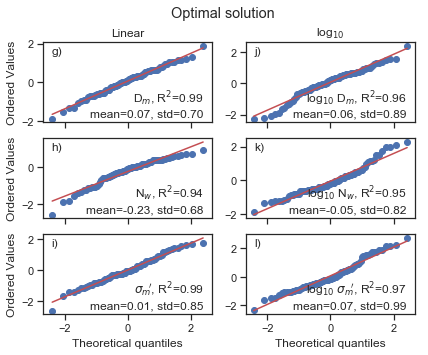

In [180]:
ncols = 2
fig, sps = plt.subplots(
    figsize=(6.66, 5), nrows=len(x_vars), ncols=ncols, sharex=True)
fig.suptitle('Optimal solution')
sps = sps.reshape((len(x_vars), ncols))

xx = 0
jj = 0

for xx, (x_name, y_name, y_uncertainty_factor) in enumerate((
    ('Linear', 'ZW', 1),
#     ('log$_{10}$', 'ZW', 1),
    ('log$_{10}$', 'ZW', 1),
#     ('Logarithmic orthogonal', 'ZW', 2),
)):

    x_vars = x_names[x_name]
    y_vars = y_names[y_name]

    for kk in range(3):

        x_var = x_vars[kk]
        thisOe = resultsOE['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)].sel(x_vars=x_var)
        passedChiTests = (thisOe.chi2value <= thisOe.chi2critical).all('chi2test')
        thisOe = thisOe.where(passedChiTests).dropna('time')
        x_err = ((
            thisOe['x_op'] - thisOe['x_truth']) / thisOe['x_op_err'])

        x_mean = x_err.mean().values
        x_std = x_err.std().values

        print(x_name, y_name, x_var, x_mean, x_std)

        (osm, osr), (slope, intercept, r) = stats.probplot(
            x_err, dist="norm", plot=sps[kk, xx], fit=True, rvalue=False)
        if kk > 0: sps[kk, xx].set_title('')
        else: sps[kk, xx].set_title(x_name)
        sps[kk, xx].text(
            0.95,
            0.05,
            '%s, R$^2$=%.2f\nmean=%.2f, std=%.2f' %
            (supporting_routines.niceKeys[x_var], r**2, x_mean, x_std),
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=sps[kk, xx].transAxes)
        sps[kk, xx].text(
            0.05,
            0.95,
            '%s)' % (abc[jj+6]),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[kk, xx].transAxes)

        if kk < 2:
            sps[kk, xx].set_xlabel("")
        if xx > 0:
            sps[kk, xx].set_ylabel("")

        jj += 1

# fig.tight_layout(pad=0.1, h_pad=0, w_pad=0.)
# fig.savefig('qq_xerr_lin_log_%s.pdf'%(version))

The comparison of the retrieval with linear (first column) and logarithmic (second column) errors reveals that the error distributions are in much better agreement with a Gaussian distribution. For all three state variables, $R^2$ values and are increased and standard deviations are closer to 1. For the retrieval version with orthogonal state variables (third column), the use of $\sigma_m\!'$ instead of $\sigma_m$ enhances $R^2$ and standard deviation even further. 

## relative errors

   \begin{equation}
   \frac{\mathbf{x}_{op} - \mathbf{x}_{truth}}{\sqrt{(\textrm{diag}( \mathbb{S}_y)}}
   \end{equation}



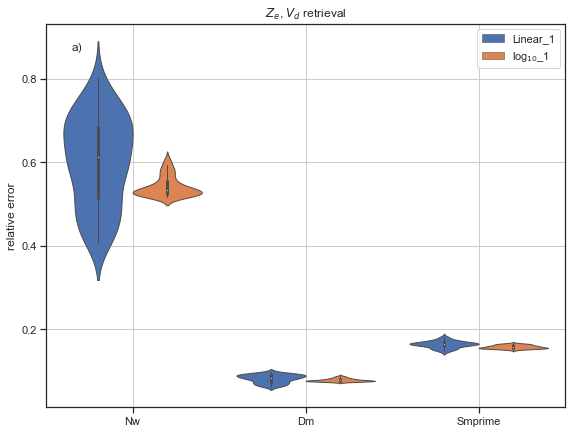

In [181]:
fig, sp = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, 
                      figsize=(8,6))
# sp = sp.ravel()
sp = [sp]


y_sets = ['ZW']
for ii, y_name in enumerate(y_sets):
    data = df[['x_var','relative error','x_name']].where(
        df['chi2Test'] == True
    ).where(
        df.y_name == y_name
    ).dropna(
        0,'any'
    )
    sns.violinplot(
        x='x_var',
        y='relative error',
        hue='x_name',
        data=data,
        saturation=1,
        linewidth=1,
        scale="width",
        ax=sp[ii],
    )
    sp[ii].set_xlabel('')
    sp[ii].set_title(supporting_routines.niceRetrievals[y_name])
    sp[ii].get_legend().remove()
    if ii in [1,3]:
        sp[ii].set_ylabel('')
    sp[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sp[ii].transAxes)
fig.tight_layout(pad=0.5)
sp[0].legend()
sp[0].grid()
# fig.savefig('y_dgf_%s.pdf'%version)

## dgf

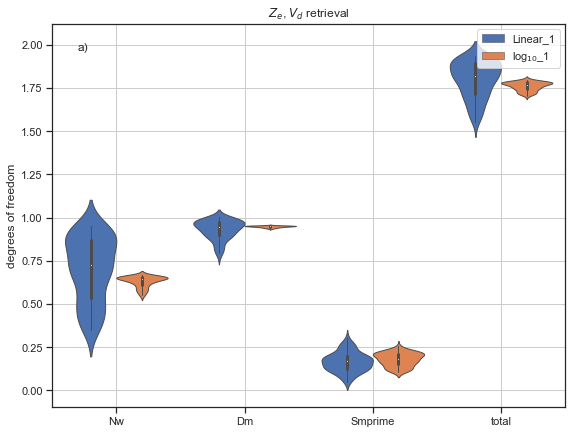

In [182]:
fig, sp = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, 
                      figsize=(8,6))
# sp = sp.ravel()
sp = [sp]


y_sets = ['ZW']
for ii, y_name in enumerate(y_sets):
    data = df.where(
        df.y_name == y_name
    ).where(
        df['chi2Test'] == True
    )
    sns.violinplot(
        x='x_var',
        y='degrees of freedom',
        hue='x_name',
        data=data,
        saturation=1,
        linewidth=1,
        scale="width",
        ax=sp[ii],
    )
    sp[ii].set_xlabel('')
    sp[ii].set_title(supporting_routines.niceRetrievals[y_name])
    sp[ii].get_legend().remove()
    if ii in [1,3]:
        sp[ii].set_ylabel('')
    sp[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sp[ii].transAxes)
fig.tight_layout(pad=0.5)
sp[0].legend()
sp[0].grid()
# fig.savefig('y_dgf_%s.pdf'%version)

## relative improvement

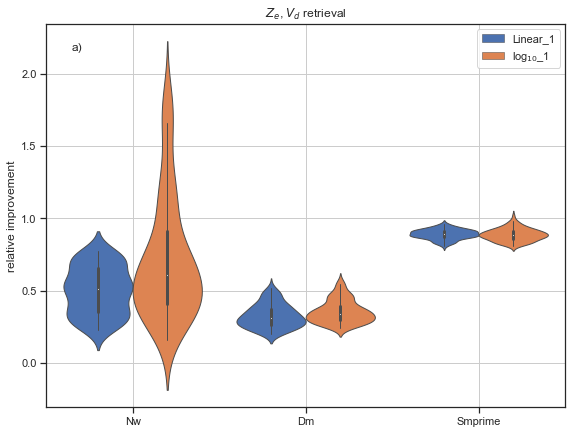

In [183]:
fig, sp = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, 
                      figsize=(8,6))
# sp = sp.ravel()
sp = [sp]


y_sets = ['ZW']
for ii, y_name in enumerate(y_sets):
    data = df[
        ['x_var','relative improvement','x_name']
    ].where(
        df.y_name == y_name
    ).where(
        df['chi2Test'] == True
    ).dropna(
        0, how='any'
    )
    sns.violinplot(
        x='x_var',
        y='relative improvement',
        hue='x_name',
        data=data,
        saturation=1,
        linewidth=1,
        scale="width",
        ax=sp[ii],
    )
    sp[ii].set_xlabel('')
    sp[ii].set_title(supporting_routines.niceRetrievals[y_name])
    sp[ii].get_legend().remove()
    if ii in [1,3]:
        sp[ii].set_ylabel('')
    sp[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sp[ii].transAxes)
fig.tight_layout(pad=0.5)
sp[0].legend()
sp[0].grid()
# fig.savefig('y_dgf_%s.pdf'%version)

Comparison partly unfair due to the sign change in the log scale variables...

## quality tests

converged [%] [86.0, 100.0]
chi2Test [%] [82.0, 92.0]
nonlinearTest [%] [83, 100]


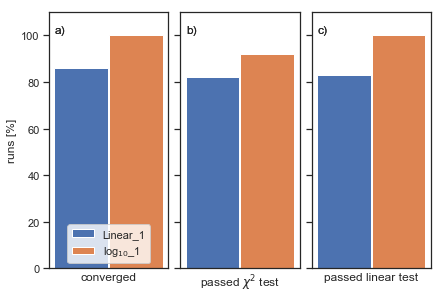

In [178]:
converged = []
nonlinearTest = []
chi2Test = []
# x_names = ['SmLin', 'Sm',  'SmprimeLog10']
# x_names = np.unique((df['x_name']).dropna())
y_name = 'ZW'

x_names1 = [
    'Linear_1', 
            'log$_{10}$_1', 
#             'log$_{10}$_2', 
]

for x_name in x_names1:
    thisII = (df['x_name']==x_name) & (df['y_name']==y_name)
    nSample = (thisII).sum()/4
    converged.append(nSample)
    nonlinearTest.append(df.where(thisII)['nonlinearTest'].sum())
    chi2Test.append((df.where(thisII)['chi2Test'].astype(float)).sum() / 4.)

fig, sps = plt.subplots(ncols=3, sharey=True, figsize=(6,4))
for xx, x_name in enumerate(x_names1):
    sps[0].bar(xx,converged[xx],label=x_name,width=0.98)
    sps[1].bar(xx,chi2Test[xx],label=x_name,width=0.98)
    sps[2].bar(xx,nonlinearTest[xx],label=x_name,width=0.98)

    sps[0].set_xticks([])
    sps[1].set_xticks([])
    sps[2].set_xticks([])
    sps[0].set_xlabel('converged')
    sps[2].set_xlabel('passed linear test')
    sps[1].set_xlabel('passed $\chi^2$ test')




    sps[0].set_ylabel('runs [%]')
    sps[0].set_ylim(0,110)
    sps[0].legend(loc='lower center')
  
    for ii in range(3):
        sps[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sps[ii].transAxes)

fig.tight_layout(pad=0.1, h_pad=0, w_pad=0.)
# fig.savefig('bar_y_%s.pdf'%version)

print('converged [%]', converged)
print('chi2Test [%]', chi2Test)
print('nonlinearTest [%]', nonlinearTest)